In [2]:
import pandas as pd
import numpy as np
import math
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Input Data
#### real - index: date, columns: real price of each ticker
#### pred - index: date, columns: pred price of each ticker

In [6]:
# Data loading and pre-processing
real = pd.read_csv("../prediction_data/Predicted_Price_All_Tickers.csv", index_col = "Date")
pred = pd.read_csv("../prediction_data/Real_Price_All_Tickers.csv", index_col = "Date")
# real.index = pd.to_datetime(real.index)
# pred.index = pd.to_datetime(pred.index)

# real dataset
real.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-11,121.848,476.541,149.014,165.109,309.643,74.195,548.350,150.138,89.240,88.261,...,829.707,162.655,194.685,196.115,231.764,43.393,221.946,62.588,142.573,351.656
2021-01-12,118.591,461.626,150.012,163.220,304.247,74.502,539.641,150.013,91.833,91.763,...,754.297,162.908,191.258,192.075,227.528,47.220,222.700,61.091,143.635,332.772
2021-01-13,119.334,460.479,151.442,163.576,308.683,73.154,543.780,148.954,93.699,88.728,...,829.057,164.070,190.770,191.738,222.829,46.436,219.248,60.245,142.094,353.523
2021-01-14,121.403,462.755,151.121,160.124,299.517,74.006,551.621,149.523,90.669,84.736,...,825.405,163.205,190.918,192.961,221.901,47.737,223.769,62.032,136.818,359.689
2021-01-15,118.513,448.630,151.870,157.222,298.121,74.833,544.409,149.843,100.438,85.288,...,792.172,163.533,186.777,188.540,221.499,48.080,221.146,60.276,135.385,361.885


In [7]:
# real dataset
pred.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-11,128.787,474.24,157.592,167.651,317.81,78.052,557.04,156.50,97.785,97.250,...,811.19,170.262,197.536,199.15,234.64,47.248,228.83,63.929,151.08,337.71
2021-01-12,128.607,471.65,158.379,168.198,320.13,77.125,552.88,155.59,99.831,95.355,...,849.44,171.246,196.309,198.58,229.38,47.506,225.62,62.936,146.67,356.81
2021-01-13,130.694,472.05,157.772,163.821,314.33,77.432,551.14,156.44,97.875,91.780,...,854.41,170.361,196.548,199.40,227.10,48.477,229.07,64.534,141.17,364.63
2021-01-14,128.717,463.27,158.747,161.085,311.11,78.106,554.64,156.65,105.611,90.790,...,845.00,170.659,193.553,195.70,226.12,48.853,227.33,63.095,140.00,383.24
2021-01-15,126.950,458.08,157.045,160.299,308.51,79.731,567.23,156.70,102.956,88.210,...,826.16,168.155,189.700,195.27,225.55,48.457,222.56,64.485,136.60,384.53


In [8]:
# global parameters
short_tol = -0.001
long_num = 5
balance = 100000.0
pct = 1
long_only = False

pred_r = pred.pct_change()
total_days = real.shape[0] - 1

In [9]:
def DivideLongShort(total, pct):
    long_budget = total * pct
    short_margin = total - long_budget
    return long_budget, short_margin

def OrderBook(budget, candidates, costs, long=True):
#     print(candidates)
    if len(candidates) == 0:
        return {}
    orders = {ticker:0 for ticker in candidates}
    order_cost = 0
    ticker_budget = float(budget)/len(candidates)
    
    for i in range(len(candidates)):
        ticker = candidates[i]
        cost = costs[i]
        if long:
            orders[ticker] = int(ticker_budget/cost)
        else:
            orders[ticker] = int(ticker_budget/cost) * -1
        order_cost += orders[ticker] * cost
    
    return orders, order_cost

def UpdateBalance(prev_balance, long_orders, long_cost, short_orders, short_cost, real_prices):
    cur_balance = prev_balance - long_cost - short_cost
    for ticker in long_orders:
        cur_balance += long_orders[ticker] * real_prices[ticker]
    try:
        for ticker in short_orders:
            cur_balance += short_orders[ticker] * real_prices[ticker]
    except: pass
    return cur_balance

def DailyTrade(beg_balance, day, long_only=False):
    
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

#     short_tickers = daily_data[daily_data['pred_r'] <= short_tol]['ticker'].tolist()
#     short_costs = daily_data[daily_data['pred_r'] <= short_tol]['cost'].tolist()
    long_tickers = daily_data.tail(long_num)['ticker'].tolist()
    long_costs = daily_data.tail(long_num)['cost'].tolist()
    short_tickers = daily_data.head(long_num)['ticker'].tolist()
    short_costs = daily_data.head(long_num)['cost'].tolist()
    
    if not long_only:

        long_budget, short_margin = DivideLongShort(beg_balance, pct)
        long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
        short_orders, short_order_cost = OrderBook(short_margin, short_tickers, short_costs, False)
        real_prices = real.iloc[day + 1]

        cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                    short_orders, short_order_cost, real_prices)
    else:
        long_budget = beg_balance
        long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
        real_prices = real.iloc[day + 1]
        cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                    {}, 0, real_prices)
    
    return cur_balance

def DailyBenchmark(beg_balance, day):
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    long_tickers = daily_data['ticker'].tolist()
    long_costs = daily_data['cost'].tolist()
    long_orders, long_order_cost = OrderBook(beg_balance, long_tickers, long_costs)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, {}, 0, real_prices)
    
    return cur_balance

In [10]:
tradebal = copy.copy(balance)
bmbal = copy.copy(balance)
benchmark = []
my_portfolio = []

for day in range(total_days):
    tradebal = DailyTrade(tradebal, day, long_only)
    my_portfolio.append(tradebal)
    bmbal = DailyBenchmark(bmbal, day)
    benchmark.append(bmbal)
    
r_my = []
for x, y in zip(my_portfolio[:-1], my_portfolio[1:]):
    r_my.append((y - x) / x)
    
r_bm = []
for x, y in zip(benchmark[:-1], benchmark[1:]):
    r_bm.append((y - x) / x)
    
r_my = np.array(r_my)
r_bm = np.array(r_bm)
sharpe = (r_my.mean() - r_bm.mean()) / (r_my - r_bm).std()

print('Benchmark final: ', bmbal)
print('My Portfolio final: ', tradebal)
print('Sharpe Ratio: ', sharpe)

Benchmark final:  103112.30799999992
My Portfolio final:  87445.02499999988
Sharpe Ratio:  -0.15059202159168056


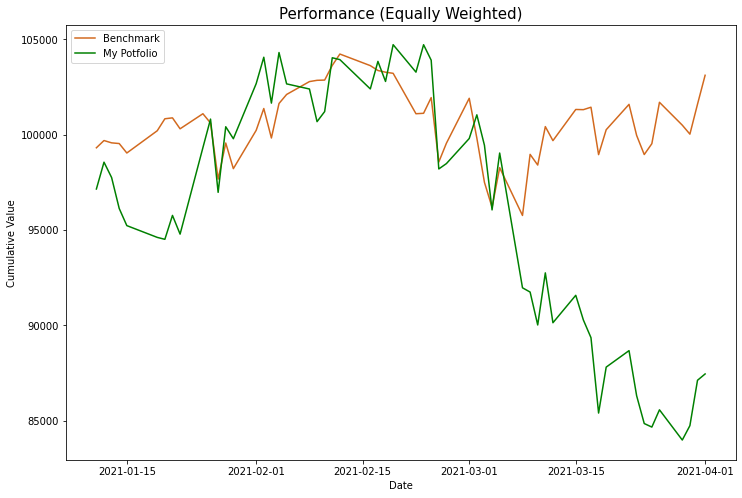

In [11]:
x = pd.to_datetime(real.index)[:-1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)  
ax.plot(x, benchmark, '-', color="chocolate", label='Benchmark')
ax.plot(x, my_portfolio, '-', color="green", label='My Potfolio')

# set xticks
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# fmt_day = mdates.DayLocator()
# ax.xaxis.set_minor_locator(fmt_day)
# fig.autofmt_xdate()

plt.legend(loc='upper left')
plt.title("Performance (Equally Weighted)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Cumulative Value")

plt.show()